In [1]:
# basic imports
import numpy as np
import sys,os,h5py,math
import matplotlib.pyplot as plt
from argparse import Namespace

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import pytorch_lightning as pl

# Personal imports
sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
from lib.metrics import accuracy,weighted_aucs

chpt_path = None

## DanQ

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        
    def __len__(self): return len(self.x)

    def __getitem__(self, i): return self.x[i].long(), self.y[i].float()

In [3]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.model = models.DanQ()
        self.bs = bs #batch size
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {}#{'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat, y)}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {}#{'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y_pred = F.softmax(y_hat,dim=1).detach().cpu()
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        trn_ds = CustomDataset(X_train,y_train)
        trn_dl = DataLoader(trn_ds, batch_size=self.bs,shuffle=True, num_workers=6)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = CustomDataset(X_valid,y_valid)
        vld_dl = DataLoader(vld_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        test = np.load('../data/Processed/test.npz')
        X_test = torch.tensor(test['arr_0'][:])
        y_test = torch.tensor(test['arr_1'][:])
                              
        tst_ds = CustomDataset(X_test,y_test)
        tst_dl = DataLoader(tst_ds, batch_size=self.bs,shuffle=False, num_workers=6)
        return tst_dl

In [4]:
exp = Experiment(bs=512)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data',log_gpu_memory='min_max')    
trainer.fit(exp) 
# #trainer.test()

Loading training dataset


Validation sanity check:   0%|          | 0/5 [00:00<?, ?batch/s]

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
exp = Experiment(bs=512)
chpt_path = '../data/lightning_logs/version_4/checkpoints/_ckpt_epoch_1.ckpt'
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
# exp.cuda()
trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.1,val_percent_check=0.5,
                     test_percent_check=0.1, default_save_path='../data',log_gpu_memory='min_max')
trainer.test(exp)

## Transformer XL

In [ ]:
import transformers as ts

In [ ]:
class LMDataset(Dataset):
    def __init__(self,x,y,mem_len):
        super(LMDataset,self).__init__()
        self.x, self.y = x,y
        self.n = x.shape[0]*math.ceil(1000/mem_len)
        
    def __len__(self): return self.n
    def __getitem__(self, i): 
        (b_idx,seq_idxs, seq_start) = i
        x = self.x[b_idx,seq_idxs[0]:seq_idxs[1]].long()
        inp,tgt = x[:-1], x[1:]
        return inp,tgt,seq_start
    
class LMSampleR(Sampler):
    def __init__(self, ds, bs,mem_len):
        self.ds, self.bs = ds, bs
        self.mem_len = mem_len
        
    def __len__(self): return len(self.ds)
    
    def __iter__(self):
        for i in range(0,self.ds.x.shape[0],self.bs):
            for j in range(0,1000,self.mem_len):
                seq_idxs = (j,j+self.mem_len+1)
                for k in range(self.bs):
                    b_idx = i+k
                    seq_start = j==0 
                    yield (b_idx,seq_idxs, seq_start) # (bs,seq_len)

In [ ]:
class TransXL_LM(nn.Module):
    def __init__(self,cfg):
        super(TransXL_LM, self).__init__()
        self.cfg = cfg
        self.core = ts.TransfoXLModel(cfg)
        self.lm_head = nn.Linear(self.cfg.d_model,self.cfg.vocab_size)
        
    def forward(self,x,mems=None):
        last_hidden_state,  mems = self.core(x,mems)
        out = self.lm_head(last_hidden_state)
        return out, mems

In [ ]:
class Experiment(pl.LightningModule):

    def __init__(self,bs):
        super(Experiment, self).__init__()
        self.cfg = ts.TransfoXLConfig(vocab_size=4, d_model=64, d_embed=8, n_head=4, d_head=16, d_inner=128, 
                             n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )
        self.model = TransXL_LM(self.cfg)
        self.bs = bs #batch size
        self.loss_fn = nn.CrossEntropyLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y, new_mem = batch
        self.mem = None if new_mem[0] else self.mem
        y_hat, self.mem = self.forward(x)
        return {'val_loss': self.loss_fn(y_hat.view(-1,self.cfg.vocab_size), y.view(-1))}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

#     def test_step(self, batch, batch_idx):
#         x, y, new_mem = batch
#         self.mem = None if new_mem[0] else self.mem
#         y_hat, self.mem = self.forward(x)
#         y_pred = F.softmax(y_hat,dim=1).detach().cpu()
#         return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred, 'y_true':y.cpu()}

#     def test_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         y_preds = torch.cat([x['y_pred'] for x in outputs])
#         y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
#         roc_auc = weighted_auc(y_preds,y_trues, self.class_weights)
        
        tensorboard_logs = {'test_loss': avg_loss,'roc_auc':roc_auc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        
        trn_ds = LMDataset(X_train,y_train,self.cfg.mem_len)
        splr   = LMSampleR(trn_ds,self.bs,self.cfg.mem_len)
        trn_dl = DataLoader(trn_ds, self.bs,sampler=splr,pin_memory=True)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = LMDataset(X_valid,y_valid,self.cfg.mem_len)
        splr   = LMSampleR(vld_ds,self.bs,self.cfg.mem_len)
        vld_dl = DataLoader(vld_ds,self.bs,sampler=splr,pin_memory=True)
        return vld_dl
    
#     @pl.data_loader
#     def test_dataloader(self):
#         test = np.load('../data/Processed/test.npz')
#         X_test = torch.tensor(test['arr_0'][:])
#         y_test = torch.tensor(test['arr_1'][:])
                              
#         tst_ds = LMDataset(X_test,y_test,self.cfg.mem_len)
#         splr   = LMSampleR(tst_ds,self.bs,self.cfg.mem_len)
#         tst_dl = DataLoader(tst_ds,self.bs,sampler=splr,pin_memory=True)
#         return tst_dl

In [ ]:
exp = Experiment(bs=32)

trainer = pl.Trainer(gpus=1,max_nb_epochs=1, train_percent_check=0.01,val_percent_check=0.5,
                     default_save_path='../data')    

trainer.fit(exp)

In [ ]:
#add acc
#dataloader slow when num_workers>0
#add shuffler to samplers
#apex https://github.com/adityaiitb/pyprof2
#resnet+transformerxl

## Resnet + TransformerXL

In [2]:
class CustomDataset(Dataset):
    def __init__(self,x,y):
        super(CustomDataset,self).__init__()
        self.x, self.y = x,y
        
    def __len__(self): return len(self.x)

    def __getitem__(self, i): return self.x[i].long(), self.y[i].float()

In [3]:
# cyclic lr with restart
def lr_i(step_i,cycle_len = 1000, lrs = (3e-4,1e-5),warm_pct = 4/20):
    cycle_i = step_i%cycle_len
    warm_len = int(cycle_len*warm_pct)
    cool_len = cycle_len - warm_len
    lr_range = lrs[0]-lrs[1]
    
    if cycle_i < warm_len:
        return lrs[1] + lr_range*(cycle_i/warm_len)
    else:
        return lrs[0] - lr_range*((cycle_i-warm_len)/cool_len)
    
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,50*30,10000)
# y = list(map(lr_i,x))
# plt.figure(figsize=(20,10))
# plt.ylim([0,4e-4])
# plt.scatter(x,y)

In [4]:
# https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters,bottom = -0.0001, top=0.001):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             print(n)
            mean = p.grad.abs().mean()
#             if mean.item() == 0: print(n)
            ave_grads.append(mean)
            max_grads.append(p.grad.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    return fig

In [5]:
def plot_weight_mag(named_parameters,bottom = -0.001, top=1.5):
    '''Plots the weight magnitude through different layers in the net during training.'''
    ave_wgts = []
    max_wgts = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_wgts.append(p.abs().mean())
            max_wgts.append(p.abs().max())
    fig = plt.figure(figsize=(18,10))       
    plt.bar(np.arange(len(max_wgts)), max_wgts, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_wgts)), ave_wgts, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_wgts)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_wgts), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_wgts))
    plt.ylim(bottom = bottom, top=top) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average weight")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-weight', 'mean-weight', 'zero-weight'])
    return fig

In [6]:
class Experiment(pl.LightningModule):

    def __init__(self,model,hparams):
        super(Experiment, self).__init__()
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.class_weights = torch.load('../data/Processed/class_weights')
        
        self.bs = hparams.train['bs']
        self.lr = hparams.optim['lr']
        self.hparams = hparams
        
    def forward(self, x): return self.model(x)

    def optimizer_step(self, current_epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
        # warm up lr
        if self.trainer.global_step < 500:
            lr_scale = min(1., float(self.trainer.global_step + 1) / 200.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.lr

#         for pg in optimizer.param_groups:
#             pg['lr'] = lr_i(self.trainer.global_step) 
        idx = batch_idx-self.hparams.train['batch_acum']+1
        if idx%5000==0:
            #self.logger.experiment.add_figure('Gradients',plot_grad_flow(self.model.named_parameters()),idx)
            with torch.no_grad():
                self.logger.experiment.add_figure('Weights',plot_weight_mag(self.model.named_parameters()),idx)
            
        optimizer.step()
        optimizer.zero_grad()
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'val_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()

        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        tensorboard_logs = {'val_loss': avg_loss,'valid_roc_auc':roc_auc,'valid_pr_auc':pr_auc,'valid_acc':acc}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat, self.mem = self.forward(x)
        y_pred = torch.sigmoid(y_hat)
        return {'test_loss': self.loss_fn(y_hat, y),'y_pred':y_pred.cpu(), 'y_true':y.cpu()}

    def test_end(self, outputs,save_preds=True):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        y_preds = torch.cat([x['y_pred'] for x in outputs])
        y_trues = torch.cat([x['y_true'] for x in outputs]).byte()
        if save_preds: self.preds=[y_preds,y_trues]
            
        roc_auc, pr_auc = weighted_aucs(y_preds.cuda(),y_trues.cuda(), self.class_weights.cuda())
        acc = accuracy(y_preds,y_trues)
        print('Test ROC AUC:',roc_auc.item(),'Test PR AUC:',pr_auc.item())
        tensorboard_logs = {'test_loss': avg_loss,'test_roc_auc':roc_auc,'test_pr_auc':pr_auc,'test_acc':acc}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return eval(self.hparams.optim_name)(self.parameters(), **self.hparams.optim)

    @pl.data_loader
    def train_dataloader(self):
        print('Loading training dataset')
        train_h5 = h5py.File('../data/Processed/train.hdf5')
        X_train = torch.tensor(train_h5['X_train'][:])
        y_train = torch.tensor(train_h5['y_train'][:])
        train_h5.close()
        
        trn_ds = CustomDataset(X_train,y_train)
        trn_dl = DataLoader(trn_ds, self.bs,pin_memory=True,shuffle=True)
        return trn_dl
    
    @pl.data_loader
    def val_dataloader(self):
        valid = np.load('../data/Processed/valid.npz')
        X_valid = torch.tensor(valid['arr_0'][:])
        y_valid = torch.tensor(valid['arr_1'][:])

        vld_ds = CustomDataset(X_valid,y_valid)
        vld_dl = DataLoader(vld_ds,self.bs,pin_memory=True)
        return vld_dl
    
    @pl.data_loader
    def test_dataloader(self):
        test = np.load('../data/Processed/test.npz')
        X_test = torch.tensor(test['arr_0'][:])
        y_test = torch.tensor(test['arr_1'][:])
                              
        tst_ds = CustomDataset(X_test,y_test)
        tst_dl = DataLoader(tst_ds,self.bs,pin_memory=True)
        return tst_dl

In [7]:
#lstm
hparams = {'emb': {'vocab_size':4, 'd_emb':64},
           'resnet': {'n_res_blocks':6, 'res_k':0, 'res_p':0.01, 
                      'block_stride':[2,1]*3,'C':32,'d':4},
           'seq_model_name': 'BiLSTM', 
           'seq_model': {'d_model':512,'p':0.01},
           'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.01},
           'train': {'bs':25, 'batch_acum':4},
           'optim_name':'torch.optim.AdamW',
           'optim':{'lr':1e-4,'betas':(0.5,0.999),'weight_decay':0}
          }
# chpt_path = '../data/lightning_logs/version_19/checkpoints/_ckpt_epoch_8.ckpt'

In [7]:
#BERT
# hparams = {'emb': {'vocab_size':4, 'd_emb':64},
#            'resnet': {'n_res_blocks':3, 'res_k':16, 'res_p':0.1},
#            'seq_model_name': 'BERT', 
#            'seq_model': {'d_model':256, 'n_layer':4, 'n_head':4},
#            'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.05},
#            'train': {'bs':25, 'batch_acum':4},
#            'optim_name':'torch.optim.Adam',
#            'optim':{'lr':1e-4,'betas':(0.5,0.999)}
#           }

In [8]:
#t_xl model
# hparams = {'emb': {'vocab_size':4, 'd_emb':64},
#            'resnet': {'n_res_blocks':3, 'res_k':16},
#            'seq_model_name': 'TransXL', 
#            'seq_model': {'d_model':352, 'n_layer':6, 'n_head':4, 'd_head':16, 'd_inner':256},
#            'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.5, 'WVN':True},
#            'train': {'bs':25, 'batch_acum':4},
#            'optim_name':'torch.optim.Adam',
#            'optim':{'lr':1e-4,'betas':(0.5,0.999)}
#           }

In [ ]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])

model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])
hparams['n_params'] = model.summary()
hparams = Namespace(**hparams)

exp = Experiment(model,hparams)

if chpt_path:
    exp.load_state_dict(torch.load(chpt_path)['state_dict'])

trainer = pl.Trainer(gpus=1, fast_dev_run=False, max_nb_epochs=10, accumulate_grad_batches=hparams.train['batch_acum'],
                     train_percent_check=1, val_check_interval=0.05, use_amp=seq_model.use_amp,
                     default_save_path='../data')    
trainer.fit(exp)

Model parameters:				
Resnet part:	3406k
Sequence part:	4330k
Linear part:	33240k
Total:		41105k
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading training dataset


Epoch 1:   5%|▍         | 9016/182400 [16:31<2:14:57, 21.41batch/s, batch_nb=8799, gpu=0, loss=0.077, v_nb=34]


Epoch 1:   8%|▊         | 14517/182400 [26:40<4:50:14,  9.64batch/s, batch_nb=14196, gpu=0, loss=0.077, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  10%|▉         | 18132/182400 [33:09<2:08:08, 21.37batch/s, batch_nb=17599, gpu=0, loss=0.073, v_nb=34]


Epoch 1:  10%|█         | 18421/182400 [33:40<4:51:51,  9.36batch/s, batch_nb=17780, gpu=0, loss=0.074, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  12%|█▏        | 21190/182400 [38:36<4:32:04,  9.88batch/s, batch_nb=20549, gpu=0, loss=0.073, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  14%|█▍        | 25146/182400 [45:23<4:32:08,  9.63batch/s, batch_nb=24505, gpu=0, loss=0.073, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  15%|█▍        | 27250/182400 [48:47<1:47:17, 24.10batch/s, batch_nb=26399, gpu=0, loss=0.073, v_nb=34]


Epoch 1:  16%|█▌        | 29510/182400 [52:37<4:10:20, 10.18batch/s, batch_nb=28549, gpu=0, loss=0.072, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  17%|█▋        | 31370/182400 [55:49<4:12:23,  9.97batch/s, batch_nb=30409, gpu=0, loss=0.071, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  19%|█▉        | 35481/182400 [1:02:53<3:58:20, 10.27batch/s, batch_nb=34520, gpu=0, loss=0.069, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  20%|█▉        | 36367/182400 [1:04:12<1:41:19, 24.02batch/s, batch_nb=35199, gpu=0, loss=0.069, v_nb=34]


Epoch 1:  21%|██        | 37970/182400 [1:06:55<3:56:20, 10.19batch/s, batch_nb=36689, gpu=0, loss=0.071, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  22%|██▏       | 39530/182400 [1:09:36<3:50:42, 10.32batch/s, batch_nb=38249, gpu=0, loss=0.069, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  24%|██▍       | 43554/182400 [1:16:35<3:58:45,  9.69batch/s, batch_nb=42273, gpu=0, loss=0.070, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  25%|██▍       | 45487/182400 [1:19:43<1:34:29, 24.15batch/s, batch_nb=43999, gpu=0, loss=0.069, v_nb=34]


Epoch 1:  25%|██▌       | 46090/182400 [1:20:44<3:39:38, 10.34batch/s, batch_nb=44489, gpu=0, loss=0.069, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  26%|██▋       | 48106/182400 [1:24:14<3:55:52,  9.49batch/s, batch_nb=46505, gpu=0, loss=0.070, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  28%|██▊       | 50178/182400 [1:27:50<3:35:30, 10.23batch/s, batch_nb=48577, gpu=0, loss=0.070, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  29%|██▊       | 52201/182400 [1:31:23<3:34:45, 10.10batch/s, batch_nb=50600, gpu=0, loss=0.069, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  30%|██▉       | 54341/182400 [1:35:07<3:35:53,  9.89batch/s, batch_nb=52740, gpu=0, loss=0.069, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  30%|██▉       | 54607/182400 [1:35:22<1:27:38, 24.30batch/s, batch_nb=52799, gpu=0, loss=0.070, v_nb=34]


Epoch 1:  31%|███       | 56694/182400 [1:38:58<3:39:56,  9.53batch/s, batch_nb=54773, gpu=0, loss=0.069, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  32%|███▏      | 58906/182400 [1:42:51<3:28:20,  9.88batch/s, batch_nb=56985, gpu=0, loss=0.070, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  33%|███▎      | 60926/182400 [1:46:24<3:45:29,  8.98batch/s, batch_nb=59005, gpu=0, loss=0.069, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  34%|███▍      | 62578/182400 [1:49:20<3:20:39,  9.95batch/s, batch_nb=60657, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  35%|███▍      | 63727/182400 [1:51:08<1:21:39, 24.22batch/s, batch_nb=61599, gpu=0, loss=0.069, v_nb=34]


Epoch 1:  37%|███▋      | 67186/182400 [1:57:10<3:16:21,  9.78batch/s, batch_nb=64945, gpu=0, loss=0.069, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  38%|███▊      | 69238/182400 [2:00:49<3:08:23, 10.01batch/s, batch_nb=66997, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  39%|███▉      | 71618/182400 [2:05:01<3:05:40,  9.94batch/s, batch_nb=69377, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  40%|███▉      | 72847/182400 [2:06:59<1:15:52, 24.06batch/s, batch_nb=70399, gpu=0, loss=0.069, v_nb=34]


Epoch 1:  41%|████      | 74061/182400 [2:09:06<3:32:25,  8.50batch/s, batch_nb=71500, gpu=0, loss=0.066, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  42%|████▏     | 76598/182400 [2:13:36<2:56:04, 10.01batch/s, batch_nb=74037, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  43%|████▎     | 78601/182400 [2:17:10<2:54:13,  9.93batch/s, batch_nb=76040, gpu=0, loss=0.068, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  45%|████▍     | 81967/182400 [2:22:56<1:09:15, 24.17batch/s, batch_nb=79199, gpu=0, loss=0.067, v_nb=34]


Epoch 1:  45%|████▌     | 82458/182400 [2:23:46<2:49:46,  9.81batch/s, batch_nb=79577, gpu=0, loss=0.069, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  47%|████▋     | 85221/182400 [2:28:44<2:41:31, 10.03batch/s, batch_nb=82340, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  48%|████▊     | 87274/182400 [2:32:24<2:48:40,  9.40batch/s, batch_nb=84393, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  49%|████▉     | 89334/182400 [2:36:07<2:44:52,  9.41batch/s, batch_nb=86453, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  50%|████▉     | 91087/182400 [2:39:02<1:02:59, 24.16batch/s, batch_nb=87999, gpu=0, loss=0.065, v_nb=34]


Epoch 1:  50%|█████     | 91694/182400 [2:40:04<2:42:08,  9.32batch/s, batch_nb=88493, gpu=0, loss=0.066, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  52%|█████▏    | 93938/182400 [2:44:08<2:30:16,  9.81batch/s, batch_nb=90737, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  53%|█████▎    | 96050/182400 [2:47:57<2:24:27,  9.96batch/s, batch_nb=92849, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  53%|█████▎    | 96058/182400 [2:47:58<2:25:32,  9.89batch/s, batch_nb=92857, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  55%|█████▍    | 100210/182400 [2:55:17<57:02, 24.02batch/s, batch_nb=96799, gpu=0, loss=0.064, v_nb=34]


Epoch 1:  55%|█████▌    | 100698/182400 [2:56:07<2:16:29,  9.98batch/s, batch_nb=97177, gpu=0, loss=0.067, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  56%|█████▋    | 102958/182400 [3:00:14<2:15:45,  9.75batch/s, batch_nb=99437, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  58%|█████▊    | 105578/182400 [3:05:00<2:10:39,  9.80batch/s, batch_nb=102057, gpu=0, loss=0.066, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  59%|█████▉    | 107641/182400 [3:08:46<2:07:34,  9.77batch/s, batch_nb=104120, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  60%|█████▉    | 109327/182400 [3:11:37<50:12, 24.25batch/s, batch_nb=105599, gpu=0, loss=0.064, v_nb=34]


Epoch 1:  60%|██████    | 110110/182400 [3:12:59<2:01:59,  9.88batch/s, batch_nb=106269, gpu=0, loss=0.065, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  62%|██████▏   | 112450/182400 [3:17:16<2:06:06,  9.25batch/s, batch_nb=108609, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  63%|██████▎   | 115030/182400 [3:22:00<1:54:02,  9.85batch/s, batch_nb=111189, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  64%|██████▍   | 117378/182400 [3:26:18<1:52:44,  9.61batch/s, batch_nb=113537, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  65%|██████▍   | 118447/182400 [3:28:02<44:06, 24.17batch/s, batch_nb=114399, gpu=0, loss=0.064, v_nb=34]


Epoch 1:  66%|██████▌   | 119861/182400 [3:30:33<2:14:27,  7.75batch/s, batch_nb=115700, gpu=0, loss=0.066, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  67%|██████▋   | 122538/182400 [3:35:28<1:40:50,  9.89batch/s, batch_nb=118377, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  69%|██████▊   | 125074/182400 [3:40:10<1:49:06,  8.76batch/s, batch_nb=120913, gpu=0, loss=0.066, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  70%|██████▉   | 127567/182400 [3:44:32<37:53, 24.12batch/s, batch_nb=123199, gpu=0, loss=0.065, v_nb=34]


Epoch 1:  71%|███████   | 128866/182400 [3:46:53<1:34:33,  9.44batch/s, batch_nb=124385, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  72%|███████▏  | 131698/182400 [3:52:09<1:31:10,  9.27batch/s, batch_nb=127217, gpu=0, loss=0.067, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  74%|███████▎  | 134218/182400 [3:56:50<1:22:40,  9.71batch/s, batch_nb=129737, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  75%|███████▍  | 136687/182400 [4:01:11<31:31, 24.17batch/s, batch_nb=131999, gpu=0, loss=0.066, v_nb=34]


Epoch 1:  75%|███████▌  | 137434/182400 [4:02:31<1:23:37,  8.96batch/s, batch_nb=132633, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  77%|███████▋  | 139614/182400 [4:06:35<1:22:18,  8.66batch/s, batch_nb=134813, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  78%|███████▊  | 142438/182400 [4:11:52<1:09:18,  9.61batch/s, batch_nb=137637, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  79%|███████▉  | 144498/182400 [4:15:44<1:04:16,  9.83batch/s, batch_nb=139697, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  80%|███████▉  | 145807/182400 [4:17:57<25:16, 24.13batch/s, batch_nb=140799, gpu=0, loss=0.065, v_nb=34]


Epoch 1:  80%|████████  | 146830/182400 [4:19:49<1:05:44,  9.02batch/s, batch_nb=141709, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  82%|████████▏ | 149661/182400 [4:25:09<56:11,  9.71batch/s, batch_nb=144540, gpu=0, loss=0.065, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  83%|████████▎ | 151818/182400 [4:29:13<54:11,  9.40batch/s, batch_nb=146697, gpu=0, loss=0.067, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  84%|████████▍ | 153846/182400 [4:33:02<51:22,  9.26batch/s, batch_nb=148725, gpu=0, loss=0.064, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  85%|████████▍ | 154381/182400 [4:34:03<48:07,  9.70batch/s, batch_nb=149260, gpu=0, loss=0.063, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  85%|████████▍ | 154927/182400 [4:34:49<18:58, 24.12batch/s, batch_nb=149599, gpu=0, loss=0.065, v_nb=34]


Epoch 1:  88%|████████▊ | 160334/182400 [4:44:57<41:26,  8.88batch/s, batch_nb=154893, gpu=0, loss=0.064, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  89%|████████▉ | 162714/182400 [4:49:28<37:02,  8.86batch/s, batch_nb=157273, gpu=0, loss=0.063, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  90%|████████▉ | 164047/182400 [4:51:45<12:40, 24.14batch/s, batch_nb=158399, gpu=0, loss=0.064, v_nb=34]


Epoch 1:  91%|█████████ | 165374/182400 [4:54:12<33:25,  8.49batch/s, batch_nb=159613, gpu=0, loss=0.063, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  92%|█████████▏| 167094/182400 [4:57:29<28:55,  8.82batch/s, batch_nb=161333, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 1:  94%|█████████▍| 171310/182400 [5:05:32<19:13,  9.61batch/s, batch_nb=165549, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  95%|█████████▍| 173167/182400 [5:08:50<06:25, 23.94batch/s, batch_nb=167199, gpu=0, loss=0.064, v_nb=34]


Epoch 1:  96%|█████████▌| 174490/182400 [5:11:19<14:55,  8.84batch/s, batch_nb=168409, gpu=0, loss=0.065, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  97%|█████████▋| 176566/182400 [5:15:18<10:34,  9.20batch/s, batch_nb=170485, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1:  98%|█████████▊| 178814/182400 [5:19:37<06:49,  8.76batch/s, batch_nb=172733, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 1: 100%|█████████▉| 182287/182400 [5:26:02<00:04, 24.15batch/s, batch_nb=175999, gpu=0, loss=0.063, v_nb=34]


Epoch 2:   0%|          | 286/182400 [00:33<5:38:28,  8.97batch/s, batch_nb=285, gpu=0, loss=0.062, v_nb=34]      

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   1%|▏         | 2726/182400 [05:15<5:30:33,  9.06batch/s, batch_nb=2725, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   3%|▎         | 4878/182400 [09:25<5:10:45,  9.52batch/s, batch_nb=4877, gpu=0, loss=0.064, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   4%|▍         | 6890/182400 [13:19<5:12:39,  9.36batch/s, batch_nb=6889, gpu=0, loss=0.063, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   5%|▍         | 9016/182400 [17:10<2:00:52, 23.91batch/s, batch_nb=8799, gpu=0, loss=0.064, v_nb=34]


Epoch 2:   5%|▌         | 9420/182400 [17:51<4:54:41,  9.78batch/s, batch_nb=9099, gpu=0, loss=0.064, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   7%|▋         | 11874/182400 [22:37<5:28:36,  8.65batch/s, batch_nb=11553, gpu=0, loss=0.061, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:   8%|▊         | 13950/182400 [26:38<4:50:14,  9.67batch/s, batch_nb=13629, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  10%|▉         | 17398/182400 [33:22<4:48:53,  9.52batch/s, batch_nb=17077, gpu=0, loss=0.064, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  10%|▉         | 18130/182400 [34:31<1:53:19, 24.16batch/s, batch_nb=17599, gpu=0, loss=0.063, v_nb=34]


Epoch 2:  11%|█         | 19938/182400 [37:58<4:45:20,  9.49batch/s, batch_nb=19297, gpu=0, loss=0.062, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  12%|█▏        | 21974/182400 [41:57<5:16:23,  8.45batch/s, batch_nb=21333, gpu=0, loss=0.062, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  13%|█▎        | 24434/182400 [46:46<5:03:25,  8.68batch/s, batch_nb=23793, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  15%|█▍        | 26854/182400 [51:30<5:19:35,  8.11batch/s, batch_nb=26213, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  15%|█▍        | 27250/182400 [52:01<1:47:19, 24.09batch/s, batch_nb=26399, gpu=0, loss=0.062, v_nb=34]


Epoch 2:  15%|█▌        | 28058/182400 [53:29<4:31:39,  9.47batch/s, batch_nb=27097, gpu=0, loss=0.063, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  18%|█▊        | 32206/182400 [1:01:36<4:32:53,  9.17batch/s, batch_nb=31245, gpu=0, loss=0.065, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  19%|█▉        | 34550/182400 [1:06:12<4:13:48,  9.71batch/s, batch_nb=33589, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  20%|█▉        | 36367/182400 [1:09:31<1:41:10, 24.06batch/s, batch_nb=35199, gpu=0, loss=0.063, v_nb=34]


Epoch 2:  20%|██        | 36926/182400 [1:10:33<4:31:51,  8.92batch/s, batch_nb=35645, gpu=0, loss=0.062, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  21%|██▏       | 38874/182400 [1:14:23<4:44:09,  8.42batch/s, batch_nb=37593, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  24%|██▎       | 42980/182400 [1:22:30<4:05:21,  9.47batch/s, batch_nb=41699, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  25%|██▍       | 45487/182400 [1:27:12<1:35:18, 23.94batch/s, batch_nb=43999, gpu=0, loss=0.063, v_nb=34]


Epoch 2:  25%|██▌       | 45900/182400 [1:27:54<3:58:41,  9.53batch/s, batch_nb=44299, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  26%|██▋       | 47906/182400 [1:31:54<5:16:40,  7.08batch/s, batch_nb=46305, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  27%|██▋       | 49994/182400 [1:36:03<4:22:37,  8.40batch/s, batch_nb=48393, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  29%|██▊       | 52390/182400 [1:40:49<3:46:38,  9.56batch/s, batch_nb=50789, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  30%|██▉       | 54607/182400 [1:44:58<1:28:43, 24.01batch/s, batch_nb=52799, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  30%|███       | 55018/182400 [1:45:40<3:48:47,  9.28batch/s, batch_nb=53097, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  30%|███       | 55394/182400 [1:46:25<4:19:55,  8.14batch/s, batch_nb=53473, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  33%|███▎      | 59461/182400 [1:54:33<3:35:09,  9.52batch/s, batch_nb=57540, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  34%|███▍      | 61890/182400 [1:59:25<3:28:54,  9.61batch/s, batch_nb=59969, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  35%|███▍      | 63727/182400 [2:02:51<1:21:59, 24.12batch/s, batch_nb=61599, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  36%|███▌      | 65194/182400 [2:05:44<3:57:09,  8.24batch/s, batch_nb=62953, gpu=0, loss=0.061, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  37%|███▋      | 67310/182400 [2:10:00<3:21:27,  9.52batch/s, batch_nb=65069, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  38%|███▊      | 68754/182400 [2:12:55<4:04:42,  7.74batch/s, batch_nb=66513, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  40%|███▉      | 72847/182400 [2:20:53<1:16:21, 23.91batch/s, batch_nb=70399, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  41%|████      | 74678/182400 [2:24:28<3:24:22,  8.78batch/s, batch_nb=72117, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  42%|████▏     | 77081/182400 [2:29:20<3:11:14,  9.18batch/s, batch_nb=74520, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  44%|████▎     | 79670/182400 [2:34:36<3:24:30,  8.37batch/s, batch_nb=77109, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  45%|████▍     | 81967/182400 [2:38:59<1:09:20, 24.14batch/s, batch_nb=79199, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  45%|████▌     | 82686/182400 [2:40:23<4:07:22,  6.72batch/s, batch_nb=79805, gpu=0, loss=0.061, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  46%|████▋     | 84721/182400 [2:44:32<2:54:11,  9.35batch/s, batch_nb=81840, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  48%|████▊     | 86866/182400 [2:48:54<3:03:39,  8.67batch/s, batch_nb=83985, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  49%|████▉     | 89046/182400 [2:53:21<2:59:56,  8.65batch/s, batch_nb=86165, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  50%|████▉     | 91087/182400 [2:57:14<1:02:57, 24.17batch/s, batch_nb=87999, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  50%|█████     | 91800/182400 [2:58:35<2:41:33,  9.35batch/s, batch_nb=88599, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  51%|█████▏    | 93806/182400 [3:02:42<3:41:54,  6.65batch/s, batch_nb=90605, gpu=0, loss=0.063, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  53%|█████▎    | 97254/182400 [3:09:47<2:54:29,  8.13batch/s, batch_nb=94053, gpu=0, loss=0.062, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  55%|█████▍    | 100207/182400 [3:15:44<1:02:40, 21.85batch/s, batch_nb=96799, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  56%|█████▌    | 101989/182400 [3:19:31<2:26:03,  9.18batch/s, batch_nb=98468, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  57%|█████▋    | 104166/182400 [3:24:15<2:34:06,  8.46batch/s, batch_nb=100645, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  59%|█████▊    | 106990/182400 [3:30:14<2:25:46,  8.62batch/s, batch_nb=103469, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  60%|█████▉    | 108753/182400 [3:33:59<2:43:25,  7.51batch/s, batch_nb=105232, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  60%|█████▉    | 109327/182400 [3:34:56<52:36, 23.15batch/s, batch_nb=105599, gpu=0, loss=0.060, v_nb=34]


Epoch 2:  62%|██████▏   | 112749/182400 [3:42:18<2:16:41,  8.49batch/s, batch_nb=108908, gpu=0, loss=0.061, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  64%|██████▍   | 116877/182400 [3:51:32<2:07:56,  8.54batch/s, batch_nb=113036, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  65%|██████▍   | 117789/182400 [3:53:38<2:10:55,  8.22batch/s, batch_nb=113948, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  65%|██████▍   | 118449/182400 [3:54:49<50:19, 21.18batch/s, batch_nb=114399, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  67%|██████▋   | 122450/182400 [4:03:56<1:50:55,  9.01batch/s, batch_nb=118289, gpu=0, loss=0.061, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  68%|██████▊   | 124938/182400 [4:09:28<2:03:14,  7.77batch/s, batch_nb=120777, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  70%|██████▉   | 126960/182400 [4:13:59<1:45:17,  8.78batch/s, batch_nb=122799, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  70%|██████▉   | 127567/182400 [4:14:58<38:16, 23.88batch/s, batch_nb=123199, gpu=0, loss=0.060, v_nb=34]


Epoch 2:  71%|███████   | 129761/182400 [4:19:40<1:38:01,  8.95batch/s, batch_nb=125280, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  73%|███████▎  | 133709/182400 [4:28:56<1:34:30,  8.59batch/s, batch_nb=129228, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  73%|███████▎  | 133713/182400 [4:28:57<2:14:25,  6.04batch/s, batch_nb=129232, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 2:  75%|███████▍  | 136687/182400 [4:35:19<33:25, 22.80batch/s, batch_nb=131999, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  76%|███████▌  | 138341/182400 [4:38:57<1:20:01,  9.18batch/s, batch_nb=133540, gpu=0, loss=0.059, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  78%|███████▊  | 142685/182400 [4:48:22<1:28:06,  7.51batch/s, batch_nb=137884, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  80%|███████▉  | 145806/182400 [4:54:50<25:29, 23.92batch/s, batch_nb=140799, gpu=0, loss=0.060, v_nb=34]


Epoch 2:  80%|████████  | 146061/182400 [4:55:15<1:05:57,  9.18batch/s, batch_nb=140940, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  81%|████████▏ | 148289/182400 [5:00:12<1:06:09,  8.59batch/s, batch_nb=143168, gpu=0, loss=0.059, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  82%|████████▏ | 150453/182400 [5:05:12<1:29:02,  5.98batch/s, batch_nb=145332, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  84%|████████▍ | 153298/182400 [5:11:40<57:06,  8.49batch/s, batch_nb=148177, gpu=0, loss=0.060, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  85%|████████▍ | 154926/182400 [5:15:00<20:39, 22.17batch/s, batch_nb=149599, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  85%|████████▌ | 155698/182400 [5:16:36<56:52,  7.82batch/s, batch_nb=150257, gpu=0, loss=0.060, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  87%|████████▋ | 157917/182400 [5:21:47<51:36,  7.91batch/s, batch_nb=152476, gpu=0, loss=0.059, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  88%|████████▊ | 160173/182400 [5:27:00<1:01:29,  6.02batch/s, batch_nb=154732, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  89%|████████▉ | 163001/182400 [5:33:31<36:07,  8.95batch/s, batch_nb=157560, gpu=0, loss=0.060, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  90%|████████▉ | 164045/182400 [5:35:37<12:40, 24.13batch/s, batch_nb=158399, gpu=0, loss=0.061, v_nb=34]


Epoch 2:  91%|█████████▏| 166541/182400 [5:41:02<28:40,  9.22batch/s, batch_nb=160780, gpu=0, loss=0.060, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  93%|█████████▎| 168758/182400 [5:45:50<25:23,  8.96batch/s, batch_nb=162997, gpu=0, loss=0.060, v_nb=34]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  94%|█████████▍| 171198/182400 [5:51:07<21:19,  8.76batch/s, batch_nb=165437, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  95%|█████████▍| 173167/182400 [5:55:07<06:29, 23.73batch/s, batch_nb=167199, gpu=0, loss=0.060, v_nb=34]


Epoch 2:  95%|█████████▌| 173921/182400 [5:56:37<15:29,  9.12batch/s, batch_nb=167840, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  97%|█████████▋| 176094/182400 [6:01:22<18:09,  5.79batch/s, batch_nb=170013, gpu=0, loss=0.060, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  98%|█████████▊| 178786/182400 [6:07:16<10:05,  5.97batch/s, batch_nb=172705, gpu=0, loss=0.059, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2:  99%|█████████▉| 180810/182400 [6:11:43<02:51,  9.28batch/s, batch_nb=174729, gpu=0, loss=0.061, v_nb=34]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 2: 100%|█████████▉| 182287/182400 [6:14:39<00:04, 23.99batch/s, batch_nb=175999, gpu=0, loss=0.061, v_nb=34]


Epoch 3:   1%|          | 1381/182400 [03:07<5:32:18,  9.08batch/s, batch_nb=1380, gpu=0, loss=0.058, v_nb=34]    

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:   3%|▎         | 4573/182400 [10:16<8:41:24,  5.68batch/s, batch_nb=4572, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:   4%|▍         | 6934/182400 [15:26<6:22:18,  7.65batch/s, batch_nb=6933, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:   5%|▍         | 9016/182400 [19:38<1:59:04, 24.27batch/s, batch_nb=8799, gpu=0, loss=0.059, v_nb=34]


Epoch 3:   5%|▌         | 9730/182400 [21:07<6:17:47,  7.62batch/s, batch_nb=9409, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:   6%|▌         | 10041/182400 [21:47<5:28:33,  8.74batch/s, batch_nb=9720, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 3:   8%|▊         | 14317/182400 [31:05<5:16:30,  8.85batch/s, batch_nb=13996, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:   9%|▉         | 17138/182400 [37:13<5:28:39,  8.38batch/s, batch_nb=16817, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  10%|▉         | 18130/182400 [39:04<1:53:40, 24.09batch/s, batch_nb=17599, gpu=0, loss=0.058, v_nb=34]


Epoch 3:  11%|█         | 19754/182400 [42:31<6:29:28,  6.96batch/s, batch_nb=19113, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  13%|█▎        | 22957/182400 [49:41<6:04:25,  7.29batch/s, batch_nb=22316, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  14%|█▍        | 25130/182400 [54:33<5:14:48,  8.33batch/s, batch_nb=24489, gpu=0, loss=0.060, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  15%|█▍        | 27250/182400 [59:02<1:48:36, 23.81batch/s, batch_nb=26399, gpu=0, loss=0.060, v_nb=34]


Epoch 3:  16%|█▋        | 30034/182400 [1:05:12<7:07:43,  5.94batch/s, batch_nb=29073, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  18%|█▊        | 32373/182400 [1:10:35<6:07:31,  6.80batch/s, batch_nb=31412, gpu=0, loss=0.058, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  19%|█▉        | 34974/182400 [1:16:32<6:00:54,  6.81batch/s, batch_nb=34013, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  20%|█▉        | 36369/182400 [1:19:20<1:41:46, 23.92batch/s, batch_nb=35199, gpu=0, loss=0.060, v_nb=34]


Epoch 3:  21%|██▏       | 38780/182400 [1:24:41<4:37:25,  8.63batch/s, batch_nb=37499, gpu=0, loss=0.058, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  23%|██▎       | 41306/182400 [1:30:27<5:08:37,  7.62batch/s, batch_nb=40025, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  24%|██▍       | 43374/182400 [1:35:14<5:21:13,  7.21batch/s, batch_nb=42093, gpu=0, loss=0.058, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  25%|██▍       | 45484/182400 [1:39:49<1:38:22, 23.19batch/s, batch_nb=43999, gpu=0, loss=0.058, v_nb=34]


Epoch 3:  25%|██▌       | 45825/182400 [1:40:28<4:53:02,  7.77batch/s, batch_nb=44224, gpu=0, loss=0.060, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  28%|██▊       | 50214/182400 [1:50:38<5:30:30,  6.67batch/s, batch_nb=48613, gpu=0, loss=0.060, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  29%|██▉       | 52790/182400 [1:56:32<3:58:38,  9.05batch/s, batch_nb=51189, gpu=0, loss=0.059, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8388608.0


Epoch 3:  30%|██▉       | 54607/182400 [2:00:25<1:32:58, 22.91batch/s, batch_nb=52799, gpu=0, loss=0.060, v_nb=34]


Epoch 3:  30%|███       | 54741/182400 [2:00:35<4:18:03,  8.24batch/s, batch_nb=52820, gpu=0, loss=0.060, v_nb=34] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4194304.0


Epoch 3:  30%|███       | 54991/182400 [2:01:09<4:26:08,  7.98batch/s, batch_nb=53070, gpu=0, loss=0.060, v_nb=34] 

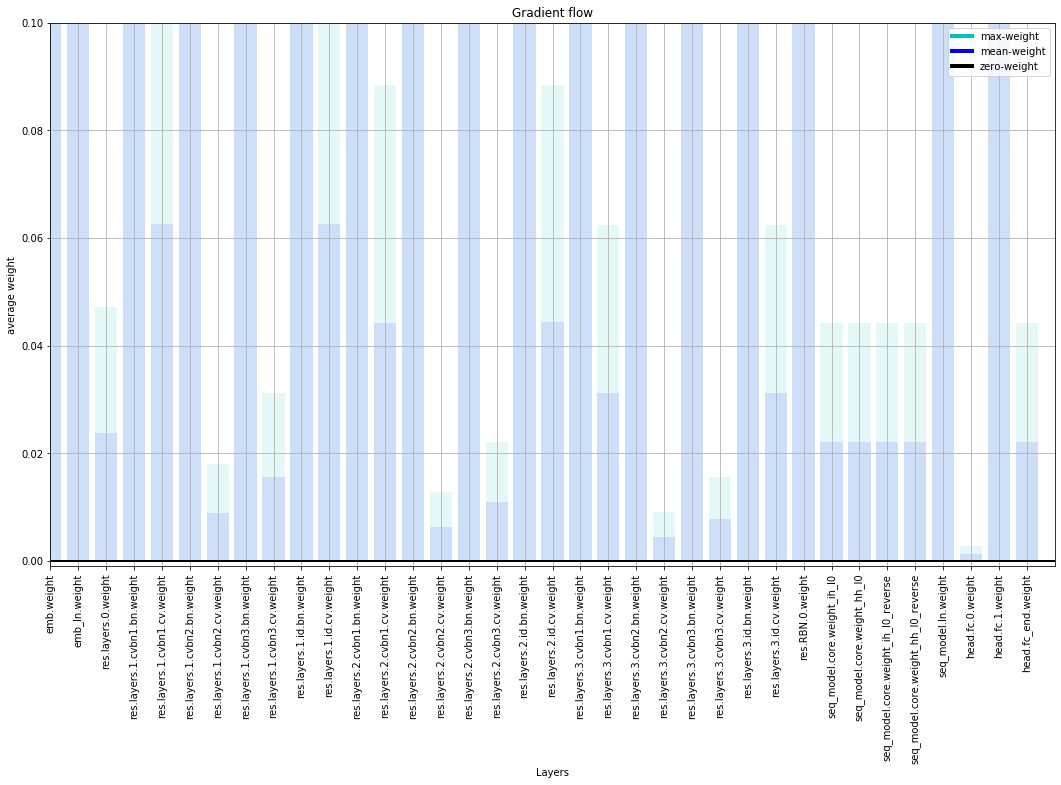

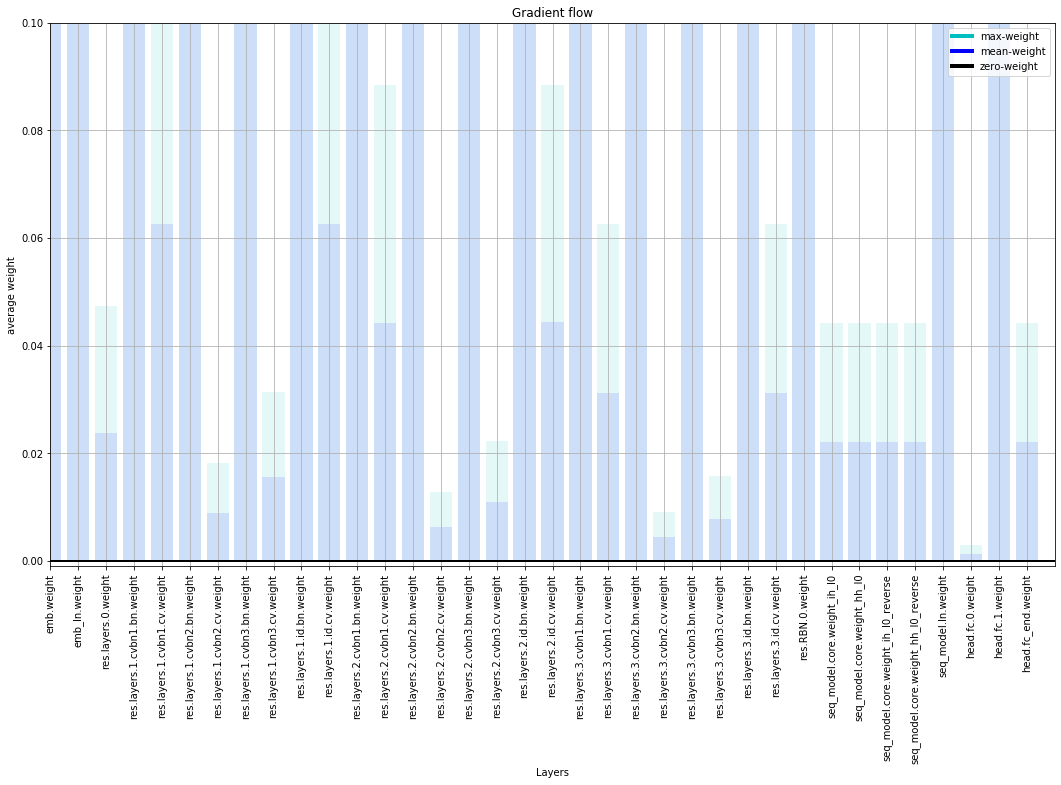

In [14]:
# loss_fn = nn.BCEWithLogitsLoss()
# op = torch.optim.Adam(model.parameters(), lr=1e-4,betas=(0.5,0.999))
# # plt.figure(figsize=(20,15))
# for i,(x,y) in enumerate(exp.val_dataloader()[0]):
#     op.zero_grad()
#     x,y = x.cuda(),  y.cuda()
#     y_hat, mem = model(x)
#     loss = loss_fn(y_hat, y)
#     loss.backward()
# #     fig = plot_grad_flow(model.named_parameters())
#     fig = plot_weight_mag(model.named_parameters(),bottom = -0.001, top=1.5)
#     op.step()
#     if i==1:break

In [ ]:
# TODO
# find memory leak(loading train dataset on every run)
# torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
# label smoothing
# balanced valdiation
# plot activations with tensorbaord 
# or efficient net(https://arxiv.org/abs/1905.11946) in 1D https://github.com/michael-1003/EfficientNet-1D
# mish
# treat input as 2d
# add tools section to github
#implemtn nvdev to models https://www.fast.ai/2019/12/02/nbdev/

## Validation

In [12]:
trainer.test(exp)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loading training dataset


Testing: 100%|██████████| 18201/18201 [03:42<00:00, 81.95batch/s]

Test ROC AUC: 0.895789623260498 Test PR AUC: 0.43330907821655273


In [ ]:
#TODO

# https://arxiv.org/pdf/1912.01857.pdf
# https://github.com/feidfoe/AdjustBnd4Imbalance/blob/master/cifar.py
gamma = 0.1 # hparams for re_scaling https://arxiv.org/pdf/1912.01857.pdf
if args.evaluate:
    print('\nEvaluation only')
    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/o RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))

    current_state = model.state_dict()
    W = current_state['module.fc.weight']

    imb_factor = 1. / args.imbalance
    img_max = 50000/num_classes
    num_sample = [img_max * (imb_factor**(i/(num_classes - 1))) \
                     for i in range(num_classes)]

    ns = [ float(n) / max(num_sample) for n in num_sample ]
    ns = [ n**gamma for n in ns ]
    ns = torch.FloatTensor(ns).unsqueeze(-1).cuda()
    new_W = W / ns

    current_state['module.fc.weight'] = new_W
    model.load_state_dict(current_state)

    test_loss, test_acc = test(testloader, model, criterion, 
                               start_epoch, use_cuda)
    print('[w/  RS] Test Loss: %.8f, Test Acc: %.2f%%' % (test_loss, test_acc))